# Time Series Analysis

Time series is a collection of data points collected at constant time intervals, such as the tempeture of london city centre at 1pm everyday or the closing value of a stock. These are analysed to determine the long term trend so as to forecast the future.

In the cell below is the import that will be required in the following tutorial

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime

We will now read in the Airpassengers csv that has been provided in the folder and examine the head of the dataframe.

In [2]:
data = pd.read_csv('AirPassengers.csv')
print data.head()
print data.dtypes


     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
Month          object
#Passengers     int64
dtype: object


We can see in the dataframe above that we have two columns, one represents the month of passengers flying and the second represents how many passengers flew during that month. When we look at the data type of the month column we see that it is being read in as an object. To read the month column as a time series we have to pass parameters that will fromat the colum into a datetime datatype

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


The parameters above have been broken down here and purpose explained.
1. parse_dates: This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.

2. index_col: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.

3. date_parser: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined. Something similar to the dataparse function defined here can be used for this purpose.

We will then convert the dataframe into a Series object to make it easier for us to index. This is simply making into a one dimensional array instead of the 2D array we had with the dataframe

In [4]:
ts = data["#Passengers"] 
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

To get the value in the series object, this can be done in two ways: One by using the string constant of the index and the second method is to import the datetime function from the datetime library.

In [5]:
#subset by string constatnt of the index
ts['1949-01-01']

#using the datetime function
from datetime import datetime
ts[datetime(1949,1,1)]

112

In [6]:
#1. Specify the entire range:
ts['1949-01-01':'1949-05-01']

#2. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## Stationarity of a Time Series

A time series has stationarity if a shift in time doesn’t cause a change in the shape of the distribution. Basic properties of the distribution like the mean , variance and covariance are constant over time. It is important as most models make the assumption that the time seies is stationary.

The mean of the series should not be a function of time rather should be a constant. The image below has the left hand graph satisfying the condition whereas the graph in red has a time dependent mean.

![title](Mean_nonstationary.png)

The variance of the series should not a be a function of time. Following graph depicts what is and what is not a stationary series.

![title](Var_nonstationary.png)

The covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ‘red series’.

![title](Cov_nonstationary.png)

## Testing Stationarity 

The first step in seeing whether are data is stationary is to visualize the data, since we had previously turned the datframe into a series this is very easy to do and we can simply plot the series.

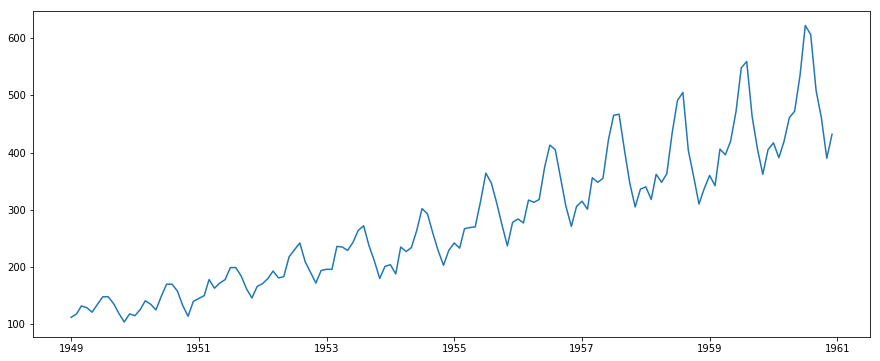

In [23]:
plt.plot(ts)

From the graph above it is clear that there is an increasing trend, however in other datasets this may not be so clear to infer from the graph. We look at more formal methods of looking at testing stationarity which include:
   Plotting Rolling Statistic: we can plot the moving average or variance and see if it varies with time
   Dickey-Fuller Test: This is one of the statistical test of stationary. The results are composed of Test statistic
                       and a critical value. If test statistic is less than critical value we can say that the time 
                       is stationary.

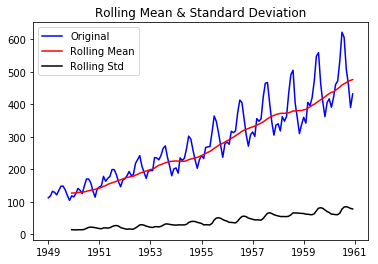

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd  = timeseries.rolling(window=12).std()
   

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
test_stationarity(ts)

## Making the Data Stationary

In most real world situations the data is unlikely to be stationary from the outset, however there have been techniques to wrangle that data to be close to stationary. Factors that make a time series non-stationary are trend and seasonality.
Trend: Varying mean over time. The price of Freddos increasing over the previous years
Seasonality: A spike in retail close to holiday times such as christmas.

To try and eliminate trend we will use transformation functions on the data the one that we will try first is a log transformation as it will penalise higher values.

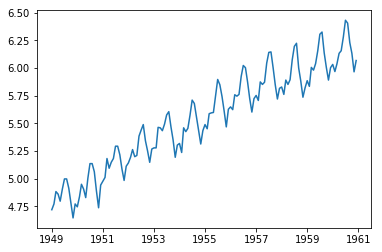

In [9]:
ts_log = np.log(ts)
plt.plot(ts_log)

### Moving Average
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

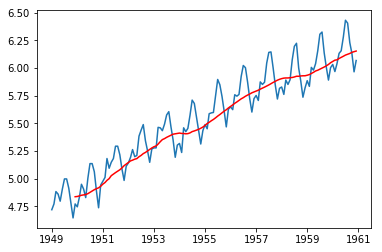

In [10]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [11]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

The first 11 values can be dropped and then we will check the stationarity

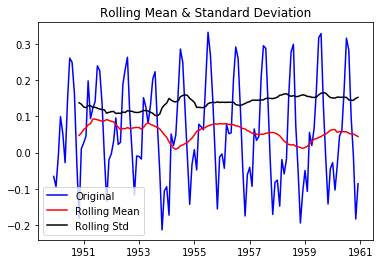

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [12]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

## Differencing

To reduce the seasonality,in this approach we take the differnce of an observation at a paticular instant with the instant before it(t - (t-1)).

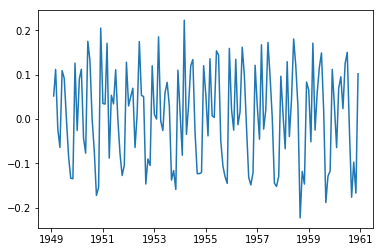

In [13]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

We will now check the stationairty of the Residuals, which is again what is left after trend and sesonality have been modelled seperately

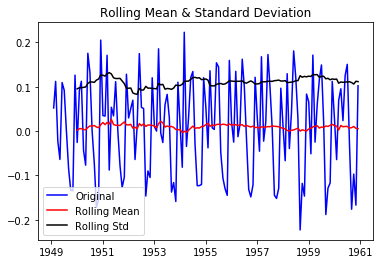

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [14]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence

## Forecasting a Time Series

We will be using an ARIMA model, which takes the parameters: timeseries, p,d and q, these are explained in the theory notebook as well as an explanation of what an ARIMA model is. To find the parameters p and q we perform the following methods: Autocorrelation function and a Partial Autocorrelation Function. 

In [15]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

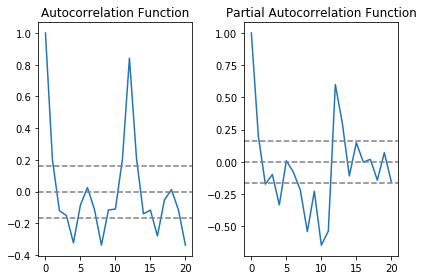

In [16]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The dotted lines on the graph represent the confidence interval, these are used to determine P and Q.

q- We get from the Autocorrelation Function graph where the line crosses the upper confidence interval for the first time which in this case is 2.

p- We get from the Partial Autocorrelation Function graph where it crosses the upper confidence interval for the first time which is also 2.

### Model

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.0292')

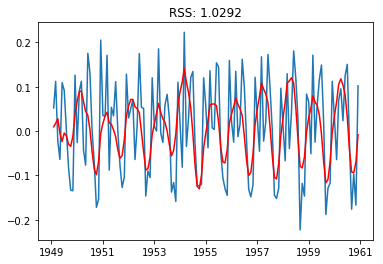

In [17]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Now that we have predicted results we will have to rescale them back to the original scale to compare to the original timer series, as we previously transformed them using the logarithim function.

In [18]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


If you notice the value of 1949-01-01 is missing this is because we took lag of one.The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number.

In [19]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

In [20]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

We will now plot our predictions against the original time series in its original scale.

Text(0.5,1,'RMSE: 90.1046')

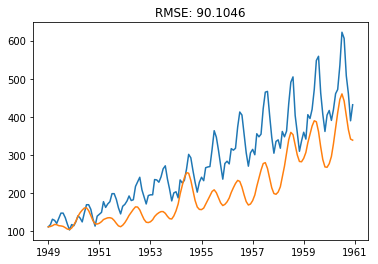

In [21]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))